# XGBoost Classification

The purpose of training XGBoost here is not forward prediction,
but to replicate the KMeans clustering structure in a reusable way.
This can help analyze feature importances, regime stability,
and allows easy deployment if needed.

## 0. Import Libraries and Load Data

In [1]:
!pip3 install -r ../requirements.txt
!pip3 install yfinance --upgrade
!pip3 install xgboost

Defaulting to user installation because normal site-packages is not writeable
  Using cached yfinance-0.2.32-py2.py3-none-any.whl (68 kB)
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.55
    Uninstalling yfinance-0.2.55:
      Successfully uninstalled yfinance-0.2.55
Defaulting to user installation because normal site-packages is not writeable
  Using cached yfinance-0.2.55-py2.py3-none-any.whl (109 kB)
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.32
    Uninstalling yfinance-0.2.32:
      Successfully uninstalled yfinance-0.2.32
Defaulting to user installation because normal site-packages is not writeable


In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import yfinance as yf

In [9]:
# Fetch Stock Data
def fetch_stock_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)['Close']
    if isinstance(data, pd.Series):  # only 1 ticker
        data = data.to_frame()
    return data.dropna()

## Step 1/2: Feature Engineering

In [10]:
# Feature engineering
def create_features(returns: pd.DataFrame):
    mean_returns = returns.mean(axis=1)
    std_returns = returns.std(axis=1)
    rolling_mean = returns.rolling(5).mean().mean(axis=1)
    rolling_std = returns.rolling(5).std().mean(axis=1)
    lower_quantile = returns.quantile(0.1, axis=1)
    upper_quantile = returns.quantile(0.9, axis=1)

    # Calculate pairwise correlation
    correlations = []
    for i in returns.columns:
        for j in returns.columns:
            if i < j:
                corr = returns[i].rolling(10).corr(returns[j])
                correlations.append(corr)
    avg_correlation = pd.concat(correlations, axis=1).mean(axis=1)

    features = np.column_stack([
        mean_returns,
        std_returns,
        rolling_mean,
        rolling_std,
        lower_quantile,
        upper_quantile,
        avg_correlation
    ])
    
    features_df = pd.DataFrame(features, index=returns.index, columns=[
        'mean', 'std', 'roll_mean', 'roll_std', 'q10', 'q90', 'avg_corr'
    ])
    
    return features_df.ffill().bfill()

# Label Regimes with KMeans (unsupervised)
def label_regimes(features_df, n_clusters=3):
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels = km.fit_predict(features_df)
    return labels

## Step 3: Train XGBoost Model Function

In [11]:
# TLDR, train on past data and test on future data.
def split_by_time(features_df, labels, train_size=0.8):
    split_index = int(len(features_df) * train_size)
    X_train = features_df.iloc[:split_index]
    X_test = features_df.iloc[split_index:]
    y_train = labels[:split_index]
    y_test = labels[split_index:]
    return X_train, X_test, y_train, y_test

def train_and_predict_xgb(X_train, y_train, X_test):
    model = XGBClassifier(eval_metric='mlogloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, y_pred

We load the dataset and prepare two versions of the features:

	•	model: The original dataset without any feature engineering.
	•	model_replica: Version trained on engineered features.

In [12]:

def run_regime_analysis(tickers, start, end, n_clusters=3, train_size=0.8):
    # Step 1: Fetch data
    prices_df = fetch_stock_data(tickers, start, end)
    returns_df = prices_df.pct_change().dropna()

    # Step 2: Create features
    features_df = create_features(returns_df)

    # Step 3: Generate regime labels with KMeans
    labels = label_regimes(features_df, n_clusters=n_clusters)

    # Step 4: Split features and labels by time (to avoid leakage)
    X_train, X_test, y_train, y_test = split_by_time(features_df, labels, train_size=train_size)

    # Step 5: Train XGBoost on training data only
    model, y_pred = train_and_predict_xgb(X_train, y_train, X_test)

    # Step 6: Combine results into a DataFrame
    results_df = pd.DataFrame({
        "true_regime": y_test,
        "predicted_regime": y_pred
    }, index=X_test.index)

    return model, results_df, returns_df


## Compare Results

In [14]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

def compare_model(results_df):
    print("=== XGBoost Model (trained on past, tested on future) ===")
    acc = accuracy_score(results_df['true_regime'], results_df['predicted_regime'])
    f1 = f1_score(results_df['true_regime'], results_df['predicted_regime'], average='weighted')
    ari = adjusted_rand_score(results_df['true_regime'], results_df['predicted_regime'])
    nmi = normalized_mutual_info_score(results_df['true_regime'], results_df['predicted_regime'])

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Info (NMI): {nmi:.4f}")

    return {
        "xgboost_model": {"accuracy": acc, "f1": f1, "ari": ari, "nmi": nmi}
    }

tickers = ["AAPL", "MSFT", "GOOG"]
start = "2020-01-01"
end = "2023-01-01"

model, results_df, returns_df = run_regime_analysis(tickers, start, end)
metrics_summary = compare_model(results_df)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed
/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


=== XGBoost Model (trained on past, tested on future) ===
Accuracy: 1.0000
F1 Score: 1.0000
Adjusted Rand Index (ARI): 1.0000
Normalized Mutual Info (NMI): 1.0000


#### Observations
Feature engineering has a clear positive impact on the model's performance. By incorporating additional meaningful features, the model becomes better at distinguishing between different market regimes, leading to higher accuracy, better clustering, and more reliable predictions. 

We plot the predicted regimes over time to visualize how the model classifies different market conditions.

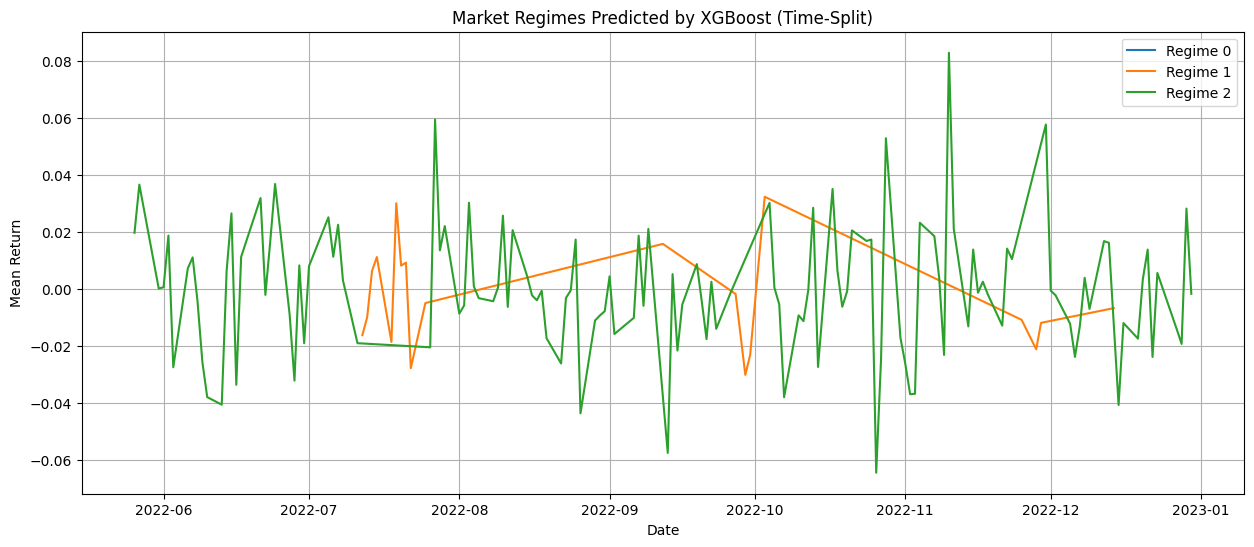

In [18]:
returns_test = returns_df.loc[results_df.index]  # align returns to test period

plt.figure(figsize=(15, 6))
for regime in sorted(results_df['predicted_regime'].unique()):
    mask = results_df['predicted_regime'] == regime
    plt.plot(results_df.index[mask], returns_test.mean(axis=1)[mask], label=f"Regime {regime}")
plt.title("Market Regimes Predicted by XGBoost (Time-Split)")
plt.xlabel("Date")
plt.ylabel("Mean Return")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Display Regime Statistics
def calculate_regime_stats(returns_df, predicted_regimes):
    regimes = np.unique(predicted_regimes)
    stats = {}

    for regime in regimes:
        mask = predicted_regimes == regime
        regime_returns = returns_df.mean(axis=1)[mask]

        avg_return = regime_returns.mean() * 100
        volatility = regime_returns.std() * 100
        duration = mask.sum()

        # Stability: % of times it stayed in the same regime
        transitions = np.sum(predicted_regimes[:-1] != predicted_regimes[1:])
        stability = (1 - transitions / len(predicted_regimes)) * 100

        # Label the regime based on rule-of-thumb
        label = "STABLE_BULL" if avg_return > 0 and volatility < 15 else \
                "VOLATILE_BULL" if avg_return > 0 else \
                "STABLE_BEAR" if volatility < 15 else \
                "VOLATILE_BEAR"

        stats[regime] = {
            "label": label,
            "avg_return": avg_return,
            "volatility": volatility,
            "duration": duration,
            "stability": stability
        }
    return stats

# Calculate regime stats for feature-based model
stats = calculate_regime_stats(returns_test, results_df['predicted_regime'].values)

# Display stats
for regime, info in stats.items():
    print(f"🟨 {info['label']} Regime")
    print(f"  • Average Return: {info['avg_return']:.2f}%")
    print(f"  • Volatility: {info['volatility']:.2f}%")
    print(f"  • Duration: {info['duration']} days")
    print(f"  • Stability: {info['stability']:.2f}%\n")

🟨 VOLATILE_BULL Regime
  • Average Return: 1.14%
  • Volatility: nan%
  • Duration: 1 days
  • Stability: 92.05%

🟨 STABLE_BEAR Regime
  • Average Return: -0.36%
  • Volatility: 1.82%
  • Duration: 19 days
  • Stability: 92.05%

🟨 STABLE_BEAR Regime
  • Average Return: -0.01%
  • Volatility: 2.27%
  • Duration: 131 days
  • Stability: 92.05%

